In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.optimize import brentq

#### Problem Set 5: Solving Aiyagari Model

##### Hasan Cetin, Lucas Belmudes

---

### The Problem

The Bellmann equation of the consumer is the following:

$$ T(V_n)(l,k) = \max_{k'} \left \{ \dfrac{(z-k')^{1-α}}{1-α} + \mathbb{E} \left \{ V_n(l',k') | l \right \} \right \}$$
$$\text{s.t.   } 0 \leq k' \leq z$$
$$\text{where   } z = wl + (1+r)k$$
$$w = (1-θ)\dfrac{K^{α}}{L}, \;\; r = θ \dfrac{K^{-α}}{L} $$

- Assume measure 1 of consumers

- We will assume $l$ is an i.i.d. idiosyncratic process centered at 1. (iid for simplicity, idiosyncracy by Aiyagari Model)

- $K^S$: capital supply is provided by the consumers/households.

- We will use EGM as in HW4 to solve the consumption-savings problem.

#### The algorithm

1. Start from an initial $K^D$ and calculate prices $w,r$

2. Solve consumption-savings problem (we used EGM for efficiency) and get $V^*$ and corresponding $Γ^*$

3. Start a simulation for N agents starting from some $k_0$ by creating an $N$ x $T$ shock grid and use $Γ^*$ to simulate their path.
     -  NOTE: Use same shocks for each iteration!!!!!
     -  NOTE: Since this shock grid will use too much RAM size (if T = 20000, N = 1000, then size = 20000 x 1000 x 8 byte = 16 x $10^8$ = 1.6 GB), after calculating path, erase this shock grid and use a seed to create the same shock grid again.

4. $K^S = \dfrac{\sum_{i=1}^{N} k_i^T}{N}$

5. Solve for $K^D$ that clears the market  i.e. $max(|K^S - K^D|) < ϵ$: we have used brentq method.

Check Kd such that $β(1+r) < 1$
Check $\bar A = Π_{ss} * A$ and in your w,r calculations 


In [19]:
class Aiyagari:

    def __init__(self, n_a = 80, n_l = 19, α = 0.4, γ = 2, δ =1, ρ = 0.95, β = 0.96
                     , σ = 0.0645, θ = 1.5, A_min = 0, A_max = 4,   error = 10e-6, max_iter = 1000, N=1000, T=10000):

        self.n_a = n_a                 # Grids for Assets.
        self.n_l = n_l                 # Markov States or labor.
        self.α = α                     # Capital Share.
        self.ρ = ρ                     # Memory of labor (Standard deviation).
        self.σ = σ                     # Volatility of labor .
        self.δ = δ                     # Depreciation.
        self.β = β                     # Discont factor.
        self.θ = θ                     # Expanding grid parameter.
        self.error = 10e-6             # Error tolerance.
        self.max_iter = 1000           # Max iterations.
        self.A_min = A_min             # Minimum assets.
        self.A_max = A_max             # Maximum assets.
        self.N = N                     # Number of agents in simulation
        self.T = T                     # Number of periods in simulation
        λ = (1-β)/β                    # Impatience parameter.
       
        # Create the transition matrix:
        # Element (i,j) is the probability of being in state l_i and going to l_j.
        # Each row gives the probability of switching states given where we are
        
        markov = qe.markov.approximation.rouwenhorst(n = n_l, ybar = 0, sigma = σ, rho= ρ)

        self.Π = markov.P   
        for n in range(1000):
            if n == 0:
                self.π =  self.Π[0,:].copy()
            else:
                self.π = self.π @ self.Π
        self.π = self.π

        # Create the vector for income shocks:
        # Compute the stationary demand supply:

        self.L = np.exp(markov.state_values)
        self.L_bar = self.π @ self.L
        self.A = A_min + (A_max - A_min) * (np.linspace(0, 1, n_a)**θ)
        self.K_min = (((λ + 1)/α)**(1/(α-1))) * self.L_bar # Minimum Capital Demand possible to ensure βR <= 1

        
        self.params = n_a, n_l, α, δ, β, γ, self.L_bar, A_min, A_max
        self.grids = self.Π, self.π, self.A, self.L

In [20]:
# Utility function
def U(c, γ):
    return (1/(1-γ)) * ((c)**(1-γ))

In [21]:
def VFI_Agent(model, K):

    # Unload parameters:

    error = model.error 
    max_iter = model.max_iter
    n_a, n_l, α, δ, β, γ, L_bar, A_min, A_max = model.params
    Π, π, A, L = model.grids

    # Aux. variables:

    iter = 0
    bounds_A = scipy.optimize.Bounds(A[0], A[-1])

    # Prices:

    r_k = α * (K/L_bar)**(α-1)
    r = r_k - δ
    w = (1-α) * (K)**(α) * (L_bar)**(-α)

    # Initial conditions:

    # Initial value function.
    # We need something increasing and concave therefore we can use U(z[i,j]):
    V_0 = np.empty((n_l, n_a), dtype = float)
    V_1 = np.empty((n_l, n_a), dtype = float)

    for i in range(n_l):

        z = w * L[i] + (1 + r) * A
        V_0[i,:] = U(z, γ) 

    # Policy for assets: 

    h_0 = np.zeros((n_l, n_a), dtype=float)
    h_1 = h_0.copy()
   
    iter = 0

    while iter < max_iter:

        for i in range(n_l):
            # Interpolate the value function given income realization:
            E_V  = scipy.interpolate.PchipInterpolator(A, Π[i,:] @ V_0, extrapolate = True)
            for j in range(n_a):
                # Given labor income and assets wealth is given by:
                z = w * L[i] + (1 + r) * A[j]
                # return function:
                def R(x):
                    return -(U(z - x, γ) + β * E_V(x))  
                bounds_A = scipy.optimize.Bounds(A[0], np.minimum(z, A[-1])) 
                x_0 = 0.5 * (A[0]+np.minimum(z, A[-1]))         
                h_1[i, j] = scipy.optimize.minimize(R, x_0, tol = error, method = 'SLSQP', bounds = bounds_A).x[0]
                V_1[i,j] = (U(z - h_1[i, j], γ) + β * E_V(h_1[i, j]))
            
        error_i = np.amax(np.abs((h_1 - h_0)/(1 + np.abs(h_0))))

        if error_i < error:

            print("Solution Found")
            print(f'Iterations', iter)
            print(f'Error', error_i)
            break
        
        else:
            #if iter % 100 == 0:
                # print("Entering iteration")
                # print(iter)
                # print("Error")
                # print('{0:.16f}'.format(error_i))
                
            V_0 = np.copy(V_1)
            h_0 = np.copy(h_1)
            iter += 1
            if iter >= max_iter:
                print("No solution")

    return V_1, h_1    

In [22]:
def simulation(Model, h, seed=1234):
    np.random.seed(seed)
    # Shock simulations for N agents in T periods
    Income_sim = np.random.choice(np.arange(0, Model.n_l), size = (Model.N,Model.T), p = Model.π)
    
    A, N, T, n_l, n_a = Model.A, Model.N, Model.T, Model.n_l, Model.n_a

    K_sim = np.zeros((N,T+1))
    K_sim[:,0] = A[-1]/2

    lin_interpolations = []
    for i in range(n_l):
        lin_interpolations.append(interp1d(A, h[i,:]))

    for n in range(N):
        for t in range(T):         
            #Given income shock find the policy simulation
            K_sim[n,t+1] = lin_interpolations[Income_sim[n,t]](K_sim[n,t])
   
    # Capital Supply
    Ks = np.sum(K_sim[:,-1])/N
    
    return Income_sim, K_sim, Ks
  

In [23]:
def equilibrium(Model, K_init = 0.212, tol = 10e-6, max_iter = 1000): 

    # Market Clearing Condition
    def MC(K):
        mc = simulation(Model, VFI_Agent(Model,K)[1])[2] - K
        print("Dist: ", mc)
        return mc

    K_eq = brentq(MC,a=Model.K_min, b=K_init) # Solve for K to clear the Market
    
    V_eq, h_eq = VFI_Agent(Model, K_eq)
    Income_sim, A_sim, Ks_eq = simulation(Model, h_eq)

    return K_eq, Ks_eq, V_eq, h_eq, Income_sim, A_sim, Ks_eq

In [24]:
Aiyagari_Model = Aiyagari()

In [54]:
Aiyagari_Model.K_min

0.20724332652381042

In [55]:
equilibrium(Aiyagari_Model)

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_49415/2092108549.py:3: RuntimeWarning: invalid value encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_49415/2092108549.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


Solution Found
Iterations 131
Error 8.807067314938841e-06
Dist:  3.3707058354608055
Solution Found
Iterations 102
Error 9.417550671959764e-06
Dist:  -0.15806692183910898
Solution Found
Iterations 104
Error 9.519404025836297e-06
Dist:  -0.1510163530285996
Solution Found
Iterations 121
Error 9.890563608781467e-06
Dist:  0.058268704298885254
Solution Found
Iterations 117
Error 9.59834627477761e-06
Dist:  -0.04067450366981709
Solution Found
Iterations 119
Error 9.590566996748878e-06
Dist:  -0.006530070967592533


KeyboardInterrupt: 

In [25]:
v, h = VFI_Agent(Aiyagari_Model, 0.20964)

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_12298/2092108549.py:3: RuntimeWarning: invalid value encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))
/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_12298/2092108549.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


Solution Found
Iterations 127
Error 8.440466355315898e-06


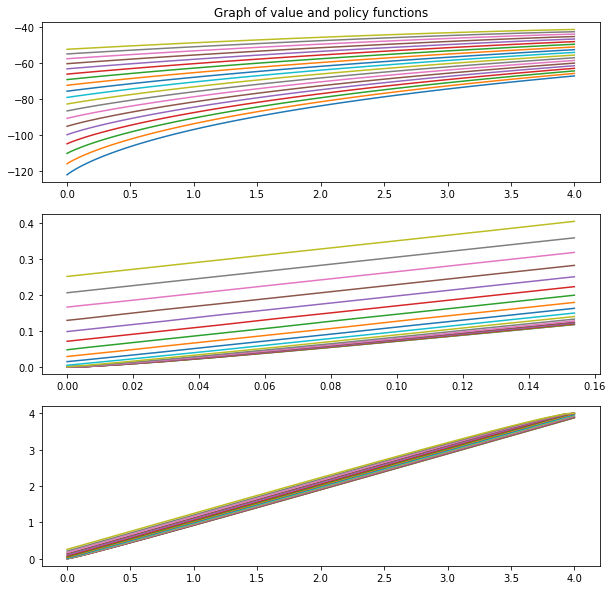

In [34]:
## Assets:

fig, ax  = plt.subplots(3, figsize=(10,10))
for i in range(Aiyagari_Model.n_l):
    ax[0].plot(Aiyagari_Model.A, v[i,:], label="Value function for each shock")
    ax[0].set_title("Graph of value and policy functions")
    ax[1].plot(Aiyagari_Model.A[0:10], h[i,:10], label="Zooming in the beginning of policy functions")
    ax[2].plot(Aiyagari_Model.A, h[i,:], label = "Policy functions for each shock")
plt.show()

In [27]:
income_sim, k_sim, ks = simulation(Model=Aiyagari_Model, h = h)

In [28]:
ks

0.23232329379751437

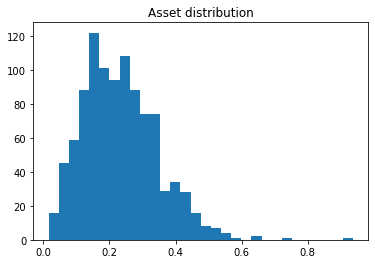

In [33]:
plt.hist(k_sim[:,-1], bins=30)
plt.title("Asset distribution")
plt.show()

In [35]:
Model2 = Aiyagari(γ=10)

The code was too slow to converge for $\gamma = 10$ case. In this Problem set, we have learnt a very valuable lesson: Python sucks. We believe that "the future" is in **C++** and we will write the Aiyagari Model in **C++** in the near future.